In [1]:
#in the last 10IQM, i didn't normalize the HR images when comparing to soup and synthsr, so I am doing that here

In [1]:
#using soup environment, python version 3.7.0
import numpy as np
import matplotlib.pyplot as plt

from utils.myutils import *
from pathlib import Path
from resize.scipy import resize
import nibabel as nib
from tqdm import tqdm
import pandas as pd


import image_similarity_measures
from image_similarity_measures.quality_metrics import ssim, psnr,issm,fsim
from vif.vif_utils import vif
import cpbd

In [2]:
#load dataframes 
vif_df = pd.read_csv('vif_df.csv')
ssim_df = pd.read_csv('ssim_df.csv')
psnr_df = pd.read_csv('psnr_df.csv')

In [3]:
#load HR, soup and synthSR
hr_path = Path("/iacl/pg22/sam/data/OASIS3/OASIS3_iso/")
hr = list(hr_path.iterdir())
hr_list = hr[0:10]



In [4]:
#create hr_image list
hr_images = []
for hr in hr_list:
    im = nib.load(hr)
    hr_img = im.get_fdata(dtype=np.float32)
    hr_images.append(hr_img)

In [5]:
#kevin list
soup_path = Path("kevin_out")
soup_list = list(soup_path.iterdir())#right order

In [6]:
#synthSR list
synth_path = Path("SynthSR/output/")
synth_list = list(synth_path.iterdir())

In [7]:
#load normalizer
from intensity_normalization.normalize.nyul import NyulNormalize

In [8]:

new_nyul_normalizer = NyulNormalize()
new_nyul_normalizer.load_standard_histogram("lr20.npy")

In [9]:
new_images = []
new_synths= []
for soup in soup_list:
    soup_arr = np.load(soup)
    new_images.append(soup_arr)
    
    
for synth in synth_list:
    synth_im = nib.load(synth)
    synth_img = synth_im.get_fdata(dtype=np.float32)
    new_synths.append(synth_img)

    
soup_normalized = [new_nyul_normalizer(image) for image in new_images]
synth_normalized = [new_nyul_normalizer(image) for image in new_synths]
hr_normalized = [new_nyul_normalizer(image) for image in hr_images]

/home/ashley/miniconda3/envs/soup/lib/python3.7/site-packages/intensity_normalization/normalize/base.py:171: UserWarning: Data contains negative values; skull-stripped functionality assumes the foreground is all positive. Provide the brain mask if otherwise.
  warnings.warn(msg)


In [10]:
#reshape synthsr image and just cut off edges
reshape_synth = []
for s in synth_normalized:
    reshape_synth.append(s[0:176,0:256,0:256])


In [11]:
synthsr_vif = []
soup_vif = []

synthsr_psnr = []
soup_psnr = []

synthsr_ssim = []
soup_ssim = []



In [12]:
#calculate vif for 3D volumes, returns the average of slices
def vif3d(vol1,vol2):
    score = 0
    for i in range(vol1.shape[0]):
        score += vif(vol1[i,:,:],vol2[i,:,:])
    
    final = score / vol1.shape[0]
    return final

In [13]:
for i in tqdm(range(0,10)):
    #hr
   
    hr_img = hr_normalized[i]
    name = hr_list[i].name
    mp = hr_img.max() - hr_img.min()
    
    
    #synthsr
    synth_img = reshape_synth[i]
   
    #soup
    soup_img = soup_normalized[i]
    
    
    #add to vif dataframe
    
    synthvif = vif3d(hr_img, synth_img)
    synthsr_vif.append(synthvif)
    
    soupvif = vif3d(hr_img, soup_img)
    soup_vif.append(soupvif)
    
    #add to psnr dataframe
    
    synthp = psnr(hr_img,synth_img, max_p = mp)
    synthsr_psnr.append(synthp)
    
    soupp = psnr(hr_img,soup_img, max_p = mp)
    soup_psnr.append(soupp)
    
    #add ssim
    
    synths = ssim(hr_img,synth_img, max_p = mp)
    synthsr_ssim.append(synths)
    
    soups = ssim(hr_img,soup_img, max_p = mp)
    soup_ssim.append(soups)
    
    #power/frequency
    #add later

  0%|                                                    | 0/10 [00:00<?, ?it/s]/home/ashley/miniconda3/envs/soup/lib/python3.7/site-packages/image_similarity_measures/quality_metrics.py:197: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)
100%|███████████████████████████████████████████| 10/10 [12:14<00:00, 73.44s/it]


In [14]:
vif_df['SynthSR'] = synthsr_vif

In [15]:
vif_df['Soup_GAN'] = soup_vif

In [16]:
ssim_df['SynthSR'] = synthsr_ssim
ssim_df['Soup_GAN'] = soup_ssim

In [17]:
psnr_df['SynthSR'] = synthsr_psnr
psnr_df['Soup_GAN'] = soup_psnr

In [18]:
ssim_df.to_csv('iqm/normal_ssim_df.csv')
psnr_df.to_csv('iqm/normal_psnr_df.csv')
vif_df.to_csv('iqm/normal_vif_df.csv')

In [56]:
psnr_df

,Unnamed: 0,Interpolated,SMORE,Soup_GAN,SynthSR
0,0,30.255451,31.499848,29.139385,15.583171
1,1,31.387608,33.077881,31.388501,21.926898
2,2,31.117654,32.300282,30.728587,18.310860
3,3,30.399723,31.886554,29.680880,16.821734
4,4,33.187909,34.110451,32.497630,20.166243
5,5,30.507555,32.044382,30.141786,16.071127
6,6,31.502278,32.839723,31.406216,18.236041
7,7,30.246048,31.621578,30.000028,19.110516
8,8,30.252202,31.806643,30.829233,18.171471
9,9,30.963414,31.870279,30.485334,16.766243


In [ ]:
#now plot figure 2

In [35]:
cpbd_df = pd.read_csv('cpbd_df.csv')
cpbd_df.drop('Unnamed: 0', axis=1, inplace=True)

In [36]:
#interp: max: 4, min: 7, median 5&9
#smore: min: 0, max: 
import statistics

In [58]:
tmp = list(psnr_df['SMORE'])
tmp.sort()
tmp

[31.49984836578369,
 31.621577739715576,
 31.80664300918579,
 31.87027931213379,
 31.88655376434326,
 32.044382095336914,
 32.300281524658196,
 32.839722633361816,
 33.07788133621216,
 34.110450744628906]

In [54]:
tmp.sort()

In [55]:
tmp

[30.24604797363281,
 30.252201557159424,
 30.255451202392575,
 30.39972305297852,
 30.50755500793457,
 30.96341371536255,
 31.117653846740726,
 31.38760805130005,
 31.502277851104736,
 33.18790912628174]

In [36]:
#plotting figure 1
import seaborn as sns

In [37]:
sns.set_theme(style="whitegrid")

In [38]:
ssim_df.columns

Index(['Unnamed: 0', 'Interpolated', 'SMORE', 'Soup_GAN', 'SynthSR'], dtype='object')

In [39]:
ssim_df.drop('Unnamed: 0', axis=1, inplace=True)

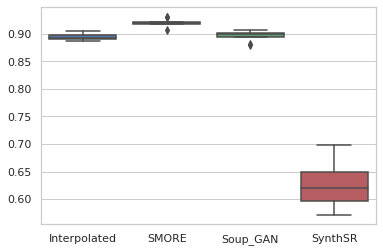

In [40]:
ax1 = sns.boxplot(data=ssim_df)

In [41]:
psnr_df.drop('Unnamed: 0', axis=1, inplace=True)

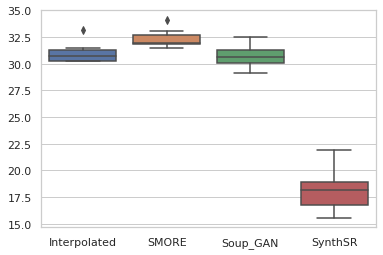

In [42]:
ax2 = sns.boxplot(data=psnr_df)

In [43]:
vif_df.drop('Unnamed: 0', axis=1, inplace=True)

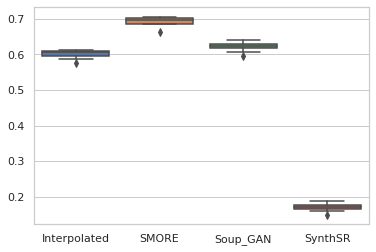

In [44]:
ax3 = sns.boxplot(data=vif_df)

In [45]:
cpbd_df = pd.read_csv('cpbd_df.csv')

In [46]:
cpbd_df.drop('Unnamed: 0', axis=1, inplace=True)

In [47]:
my_pal = {'GT':"m",'Interpolated': "b",'SMORE':sns.color_palette()[1],'Soup_GAN': "g",'SynthSR':"r"}


In [48]:
temp = cpbd_df['GT']

In [49]:
temp

0    0.698039
1    0.703282
2    0.692453
3    0.694005
4    0.682082
5    0.716631
6    0.730335
7    0.713583
8    0.701388
9    0.740426
Name: GT, dtype: float64

In [50]:
cpbd_df.drop('GT', axis=1, inplace=True)

In [51]:
cpbd_df['GT'] = temp

In [52]:
cpbd_df

,Interpolated,SMORE,Soup_GAN,SynthSR,GT
0,0.012979,0.134858,0.335283,0.281637,0.698039
1,0.008577,0.125285,0.313904,0.134227,0.703282
2,0.010089,0.111252,0.301689,0.124892,0.692453
3,0.013334,0.171785,0.316655,0.284313,0.694005
4,0.005242,0.085141,0.288314,0.119060,0.682082
5,0.017344,0.152494,0.336078,0.282129,0.716631
6,0.023477,0.170864,0.343692,0.272202,0.730335
7,0.005983,0.110057,0.301246,0.230334,0.713583
8,0.011492,0.134268,0.325503,0.297483,0.701388
9,0.006215,0.099931,0.301251,0.292204,0.740426


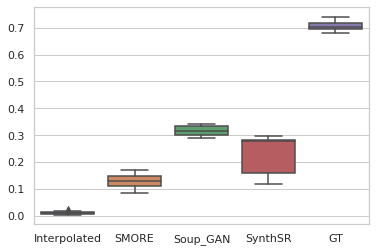

In [53]:
ax4 = sns.boxplot(data=cpbd_df, palette=my_pal)

In [54]:
ssim_fig = ax1.get_figure()
psnr_fig = ax2.get_figure()
vif_fig = ax3.get_figure()
cpbd_fig = ax4.get_figure()

In [55]:
ssim_fig.savefig('images/ssim_boxplot.png',dpi = 300)
psnr_fig.savefig('images/psnr_boxplot.png',dpi = 300)
vif_fig.savefig('images/vif_boxplot.png',dpi = 300)
cpbd_fig.savefig('images/cpbd_boxplot.png',dpi = 300)
